In [1]:
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np

In [2]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(300, 300, 3), pooling=None, classes=1000,
    classifier_activation='softmax'
)

58892288/58889256 [==============================] - 0s 0us/step


In [55]:
from tensorflow.keras import preprocessing

In [328]:
inp = keras.Input(shape=(300, 300, 3))
x = keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inp)
vgg_out = keras.layers.Flatten()(vgg(x))
#vgg_out = keras.layers.BatchNormalization()(vgg_out1)

cartoon_hidden1 = keras.layers.Dense(64, activation="relu", name="cartoon_hidden1")(vgg_out)
cartoon_hidden2 = keras.layers.Dense(20, activation="relu", name="cartoon_hidden2")(cartoon_hidden1)
cartoon_hidden3 = keras.layers.Dense(10, activation="relu", name="cartoon_hidden3")(cartoon_hidden2)
cartoon_output = keras.layers.Dense(1, activation="sigmoid", name="cartoon_output")(cartoon_hidden3)

watermark_hidden1 = keras.layers.Dense(64, activation="relu", name="watermark_hidden1")(vgg_out)
watermark_hidden2 = keras.layers.Dense(32, activation="relu", name="watermark_hidden2")(watermark_hidden1)
watermark_hidden3 = keras.layers.Dense(20, activation="relu", name="watermark_hidden3")(watermark_hidden2)
watermark_hidden4 = keras.layers.Dense(10, activation="relu", name="watermark_hidden4")(watermark_hidden3)
watermark_output = keras.layers.Dense(1, activation="sigmoid", name="watermark_output")(watermark_hidden4)

watermark_model = keras.Model(inputs=inp, outputs=watermark_output)

In [329]:
watermark_model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling_27 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_31 (Flatten)         (None, 41472)             0         
_________________________________________________________________
watermark_hidden1 (Dense)    (None, 64)                2654272   
_________________________________________________________________
watermark_hidden2 (Dense)    (None, 32)                2080      
_________________________________________________________________
watermark_hidden3 (Dense)    (None, 20)                660

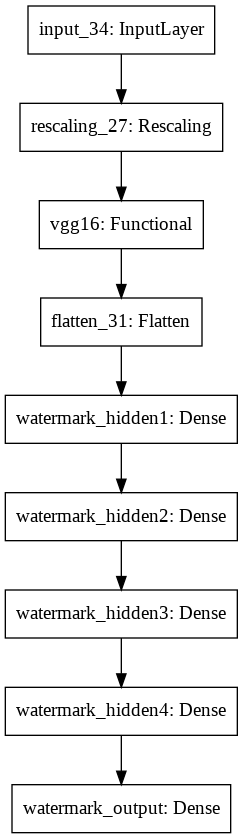

In [331]:
keras.utils.plot_model(watermark_model)

In [309]:
combined_model.output_shape
#CARTOON, WATERMARK

[(None, 1), (None, 1)]

In [330]:
watermark_model.get_layer("vgg16").trainable = False

In [50]:
model.output_shape

(None, 1)

In [51]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [340]:
data_dir = '/gdrive/MyDrive/faces'
img_height = img_width = 300
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 2081 files belonging to 2 classes.
Using 1665 files for training.
Found 2081 files belonging to 2 classes.
Using 416 files for validation.


In [276]:
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [41]:
opt = keras.optimizers.Adam(learning_rate=0.1)

In [333]:
watermark_model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy',
    metrics=["accuracy"])


In [335]:
with tf.device('/device:GPU:0'):
    watermark_model.fit(train_ds, validation_data=val_ds, epochs=1)

83/83 [==============================] - 67s 800ms/step - loss: 0.3109 - accuracy: 0.8636 - val_loss: 0.5849 - val_accuracy: 0.7320


In [344]:
%cd /content
combined_model.save("final_model")

/content
INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets


In [347]:
%cd /content
!zip -r final_model.zip /content/final_model

/content
  adding: content/final_model/ (stored 0%)
  adding: content/final_model/variables/ (stored 0%)
  adding: content/final_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/final_model/variables/variables.index (deflated 68%)
  adding: content/final_model/assets/ (stored 0%)
  adding: content/final_model/keras_metadata.pb (deflated 96%)
  adding: content/final_model/saved_model.pb (deflated 91%)


In [290]:
model.evaluate(val_ds)

21/21 [==============================] - 14s 593ms/step - loss: 0.9450 - accuracy: 0.7092


[0.9449931979179382, 0.7091875672340393]

In [314]:
cartoon_model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling_22 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 41472)             0         
_________________________________________________________________
cartoon_hidden1 (Dense)      (None, 64)                2654272   
_________________________________________________________________
cartoon_hidden2 (Dense)      (None, 20)                1300      
_________________________________________________________________
cartoon_hidden3 (Dense)      (None, 10)                210

In [336]:
def replace_weights(input_model, layers):
    for layer in layers:
        combined_model.get_layer(layer).set_weights([input_model.get_layer(layer).weights[0].numpy(), input_model.get_layer(layer).weights[1].numpy()])
    

replace_weights(watermark_model, ["watermark_hidden1", "watermark_hidden2", "watermark_hidden3", "watermark_hidden4", "watermark_output"])
                
# ["cartoon_hidden1", "cartoon_hidden2", "cartoon_hidden3", "cartoon_output"])
                
# ["watermark_hidden1", "watermark_hidden2", "watermark_hidden3", "watermark_hidden4", "watermark_output"])

In [203]:
model_cartoon.get_layer("cartoon_hidden1").weights[0].shape, model_cartoon.get_layer("cartoon_hidden1").weights[1].shape

(TensorShape([41472, 64]), TensorShape([64]))

In [205]:
combined_model.get_layer("cartoon_hidden1").weights[0].shape, combined_model.get_layer("cartoon_hidden1").weights[1].shape

(TensorShape([41472, 64]), TensorShape([64]))

In [342]:
combined_model.compile("adam", ['binary_crossentropy', None])

In [348]:
val_ds.class_names

['cartoon', 'real']

In [341]:
cartoon_model.evaluate(val_ds)

7/7 [==============================] - 6s 470ms/step - loss: 0.4103 - accuracy: 0.9351


[0.41031959652900696, 0.9350961446762085]

In [337]:
watermark_model.evaluate(val_ds)

21/21 [==============================] - 14s 601ms/step - loss: 0.5849 - accuracy: 0.7320


[0.5849326848983765, 0.7319666147232056]

In [343]:
combined_model.evaluate(val_ds)

7/7 [==============================] - 6s 472ms/step - loss: 0.4103 - cartoon_output_loss: 0.4103


[0.41031959652900696, 0.41031959652900696]

In [242]:
Y = []
for x, y in val_ds:
    Y.append(y)

Y = np.concatenate(Y)

In [223]:
Y.shape

(416, 1)

In [243]:
accuracy_score(np.around(a), Y)

0.5026575550493546

In [233]:
from sklearn.metrics import accuracy_score

In [304]:
train_ds.class_names

['cartoon', 'real']

In [295]:
watermark_classes = train_ds.class_names

In [351]:
import cv2

In [365]:
def get_results(img_path):
    cartoon_model_classes = ['cartoon/edited', 'real']
    watermark_model_classes = ['no watermark', 'watermarked']
    model = keras.models.load_model("final_model")
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = img.reshape((-1, 300, 300, 3))
    real, watermark = model.predict(img)
    return (cartoon_model_classes[int(np.around(real)[0])], watermark_model_classes[int(np.around(watermark)[0])])    


In [369]:
get_results("/gdrive/MyDrive/faces/real/images.jpg")

('real', 'watermarked')

In [355]:
cv2.imread("/gdrive/MyDrive/watermark/watermark/wood-nature-forest-path.jpg").shape

(350, 525, 3)